# 0.0 IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

from scipy import stats
from matplotlib import pylab

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from scikitplot.metrics import plot_cumulative_gain

from sklearn.linear_model import LogisticRegression

## 0.1 Loading Dataset

In [2]:
df_raw = pd.read_csv('../data/raw/train.csv')
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 0.2 Helper Functions

In [3]:
def diagnostic_plots(df, variable):
    # plot the histograms to have a quick look at the distributions
    # we can plot Q-Q plots to visualise if the variable is normally distributed
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=pylab)

    plt.show()
    
def jupyter_settings():
    %matplotlib inline
    plt.rcParams['figure.figsize'] = [20, 12]
    plt.rcParams['font.size'] = 18
    

jupyter_settings()

# Set Matplotlib defaults
# plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
# sns.color_palette("crest", as_cmap=True)
# sns.color_palette("magma", as_cmap=True)
# sns.color_palette("flare", as_cmap=True)
sns.set_theme(style="darkgrid", palette='hls')
# Increase chart size for better readability
sns.set(rc={'figure.figsize':(11,6)})

# 1.0 DATA DESCRIPTION

In [4]:
df1 = df_raw.copy()

In [5]:
cols_new = [col.lower() for col in df1.columns]
df1.columns = cols_new

In [6]:
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 1.1 Data Dimension

In [7]:
display(f'Number of rows: {df1.shape[0]}')
display(f'Number of columns: {df1.shape[1]}')

'Number of rows: 381109'

'Number of columns: 12'

## 1.2 Data Types

In [8]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Check NA

In [9]:
df1.info()
# df1.isna().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   driving_license       381109 non-null  int64  
 4   region_code           381109 non-null  float64
 5   previously_insured    381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   annual_premium        381109 non-null  float64
 9   policy_sales_channel  381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## 1.4 Data Descriptive

In [10]:
# Separete numerical and categorical features
num_attributes = df1.select_dtypes(include='number')
cat_attributes = df1.select_dtypes(exclude='number')

In [11]:
print(num_attributes.shape[1])
print(cat_attributes.shape[1])

9
3


In [12]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concat
describe_matrix = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
describe_matrix.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
describe_matrix

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0 FEATURE ENGINEERING

In [13]:
df2 = df1.copy()

In [14]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Preprocess 'vehicle_age' (eliminate '<' and '>' signals) and 'vehicle_damage'.

In [15]:
df2.vehicle_age.unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

We have 3 categories: over 2 years, between 1-2 years and below 1 year.

In [16]:
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1-2_years' if x == '1-2 Year'
                                                                                           else 'below_1_year')
df2['vehicle_damage'] = df2['vehicle_damage'].replace(['Yes', 'No'], [1, 0])

In [17]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,over_2_years,1,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,between_1-2_years,0,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,over_2_years,1,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,below_1_year,0,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,below_1_year,0,27496.0,152.0,39,0


# 3.0 DATA FILTERING

In [18]:
df3 = df2.copy()

We couldn't observe nothing odd within our describe section, so we're going to skip this section for now.

# 4.0 EXPLORATORY DATA ANALYSIS

In [19]:
df4 = df3.copy()

## 4.1. Univariate Analysis

In [20]:
df4.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

In [21]:
num_attributes.columns

Index(['id', 'age', 'driving_license', 'region_code', 'previously_insured',
       'annual_premium', 'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

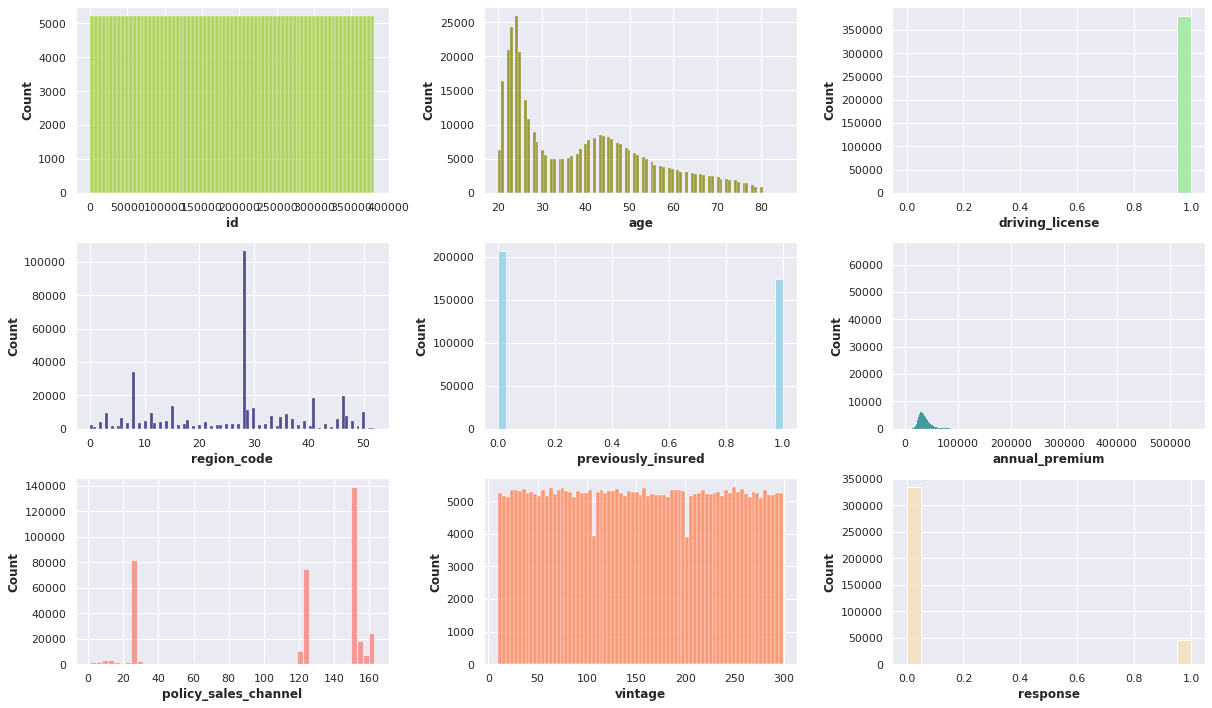

In [22]:
fig, axs = plt.subplots(3, 3, figsize=(17,10))

sns.histplot(data=df4, x=num_attributes.columns[0], kde=False, cbar=True, color="yellowgreen", ax=axs[0, 0])
sns.histplot(data=df4, x=num_attributes.columns[1], kde=False, cbar=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df4, x=num_attributes.columns[2], kde=False, cbar=True, color="lightgreen", ax=axs[0, 2])
sns.histplot(data=df4, x=num_attributes.columns[3], kde=False, cbar=True, color="midnightblue", ax=axs[1, 0])
sns.histplot(data=df4, x=num_attributes.columns[4], kde=False, cbar=True, color="skyblue", ax=axs[1, 1])
sns.histplot(data=df4, x=num_attributes.columns[5], kde=False, cbar=True, color="teal", ax=axs[1, 2])
sns.histplot(data=df4, x=num_attributes.columns[6], kde=False, cbar=True, color="salmon", ax=axs[2, 0])
sns.histplot(data=df4, x=num_attributes.columns[7], kde=False, cbar=True, color="coral", ax=axs[2, 1])
sns.histplot(data=df4, x=num_attributes.columns[8], kde=False, cbar=True, color="wheat", ax=axs[2, 2])
cbar=True, 

plt.show()

In [23]:
# num_attributes.hist();

### Gender

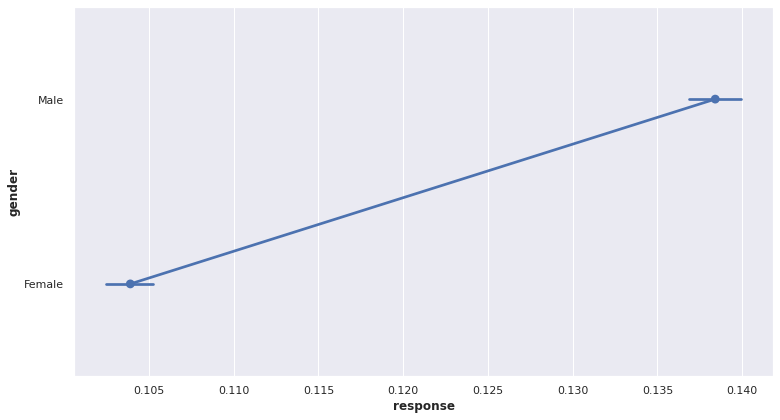

In [24]:
# diagnostic_plots(df4, 'gender')
sns.pointplot(data=df4, x='response', y='gender');

### Age

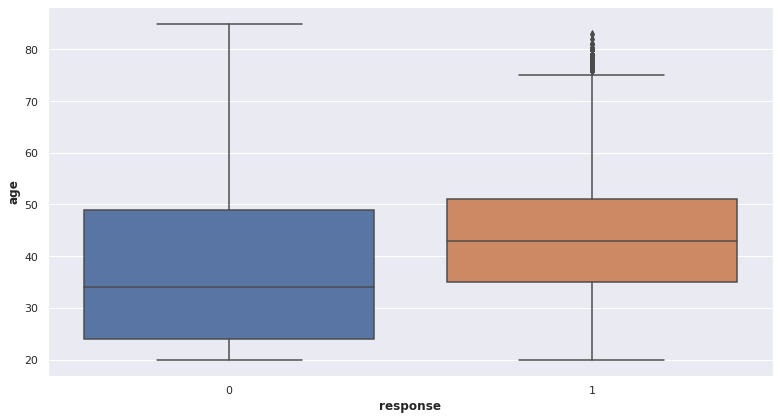

In [25]:
sns.boxplot(data=df4, x='response', y='age');

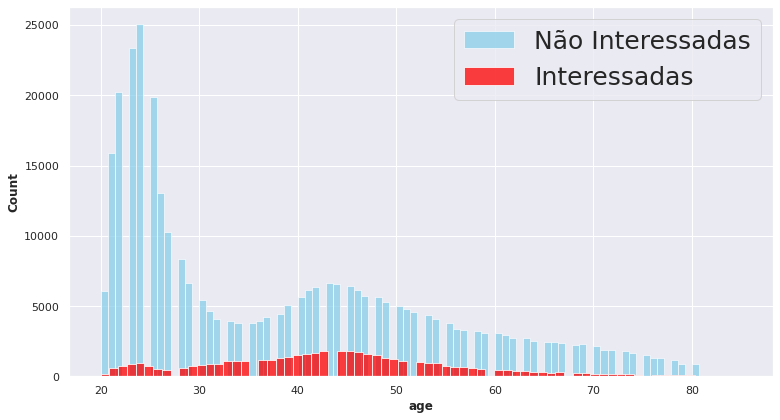

In [26]:
aux10 = df4.loc[df4['response'] == 0, 'age']
aux11 = df4.loc[df4['response'] == 1, 'age']

sns.histplot(data=aux10, color="skyblue", label="Não Interessadas", kde=False)
sns.histplot(data=aux11, color="red", label="Interessadas", kde=False)
plt.legend(fontsize=25)
plt.show()

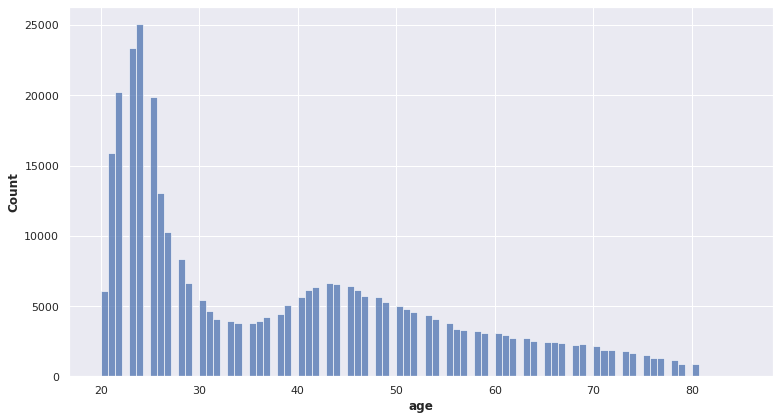

In [27]:
sns.histplot(aux10);

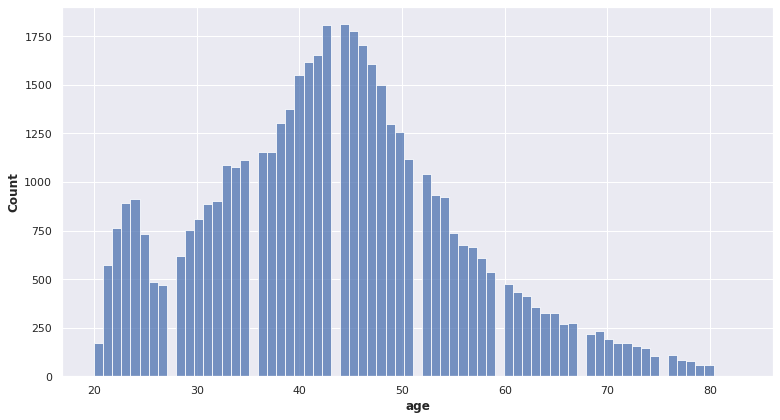

In [28]:
sns.histplot(aux11);

### Driving_license

In [29]:
aux20 = df4[['driving_license', 'response']].groupby('response').sum().reset_index()

aux20['driving_license_percentage'] = aux20['driving_license'] / aux20['driving_license'].sum()
aux20

,response,driving_license,driving_license_percentage
0,0,333628,0.877283
1,1,46669,0.122717


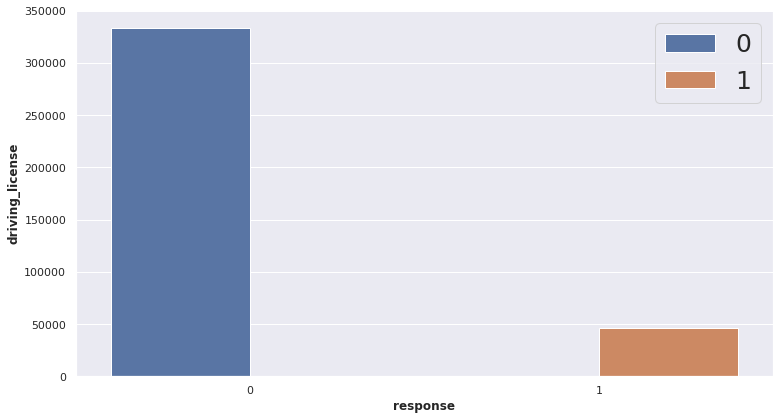

In [30]:
sns.barplot(data=aux20, x='response', y='driving_license', hue='response')
plt.legend(fontsize=25)
plt.show()

### Region_code

In [31]:
ax30 = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()

In [32]:
ax30

,region_code,response,id
0,0.0,0,1847
1,0.0,1,174
2,1.0,0,899
3,1.0,1,109
4,2.0,0,3751
...,...,...,...
101,50.0,1,642
102,51.0,0,155
103,51.0,1,28
104,52.0,0,234


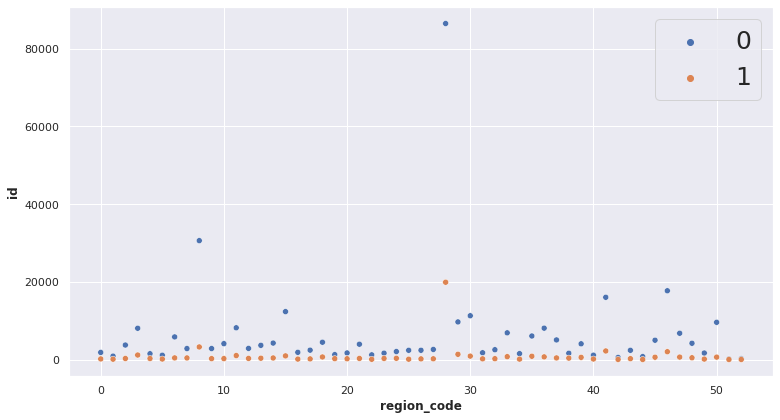

In [33]:
sns.scatterplot(data=ax30, x='region_code', y='id', hue='response')
plt.legend(fontsize=25)
plt.show()

### Previosuly_insured

In [34]:
# aqui ambas as variáveis são binárias, então devemos usar métrica estatística da frequência
df4[['previously_insured', 'response']].head() 

aux40 = pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1)
aux40

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


Esse valor está muito enviesado e pode causar vazamento de dados para o modelo: extremamente relacionado a variável resposta.


"*Se uma pessoa já tem um seguro, a chance dela querer outro é praticamente 0.*"

### Vehicle_age

In [35]:
df4[['vehicle_age', 'response']].value_counts(normalize=True, sort=False).reset_index()

,vehicle_age,response,0
0,below_1_year,0,0.413488
1,below_1_year,1,0.018897
2,between_1-2_years,0,0.434285
3,between_1-2_years,1,0.091328
4,over_2_years,0,0.029663
5,over_2_years,1,0.012338


In [36]:
aux50 = pd.crosstab(df4['vehicle_age'], df4['response']).apply(lambda x: x/x.sum(), axis=1)
aux50

response,0,1
vehicle_age,,
below_1_year,0.956295,0.043705
between_1-2_years,0.826245,0.173755
over_2_years,0.706254,0.293746


### Vehicle_damage

### Annual_premium

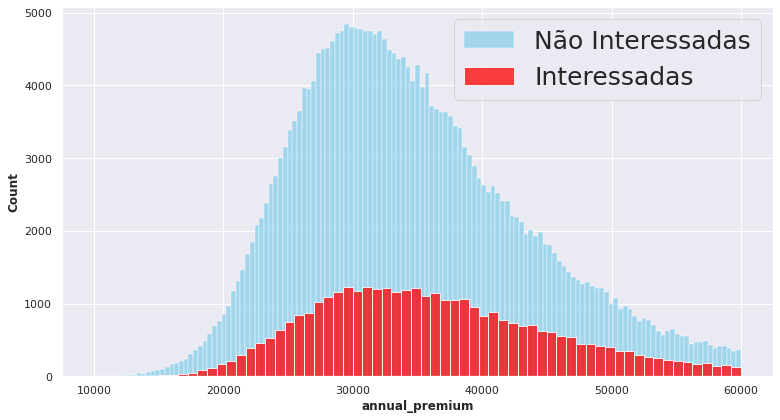

In [37]:
aux70 = df4[(df4['annual_premium'] > 10_000) & (df4['annual_premium'] < 60_000)]
aux71 = aux70.loc[aux70['response'] == 0, 'annual_premium']
aux72 = aux70.loc[aux70['response'] == 1, 'annual_premium']

sns.histplot(data=aux71, color='skyblue', label="Não Interessadas")
sns.histplot(data=aux72, color='red', label="Interessadas")
plt.legend(fontsize=25)
plt.show()


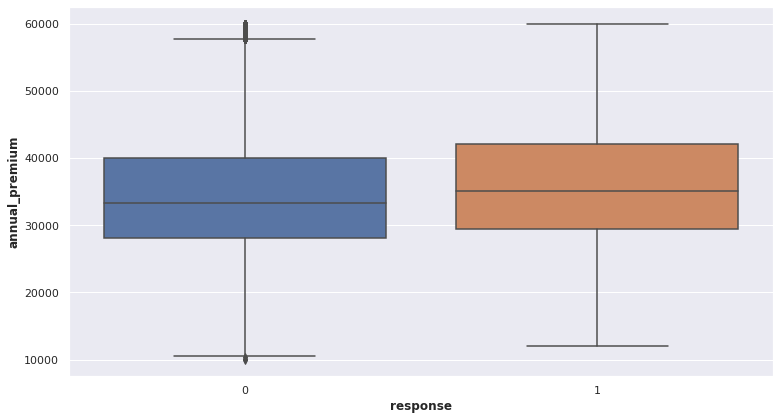

In [38]:
sns.boxplot(x='response', y='annual_premium', data=aux70);

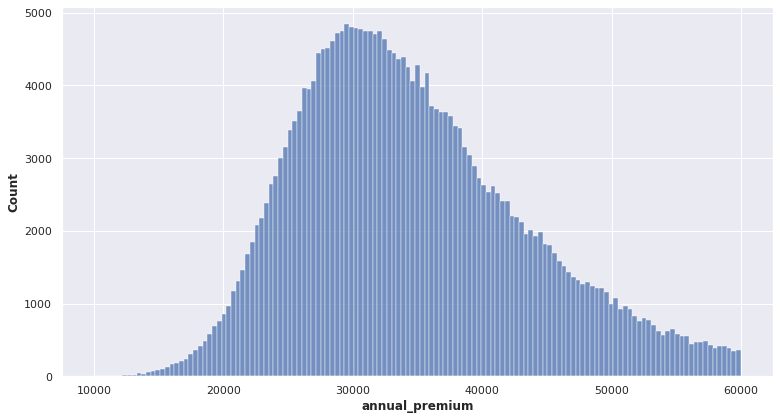

In [39]:
sns.histplot(aux71);

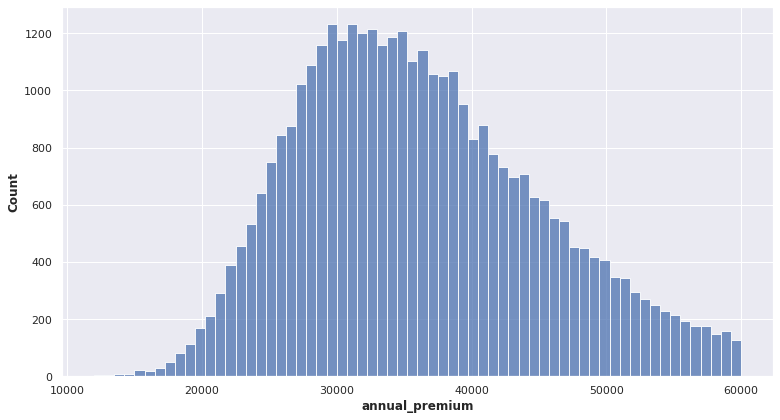

In [40]:
sns.histplot(aux72);

### Policy_sales_channel

<AxesSubplot:xlabel='response', ylabel='policy_sales_channel'>

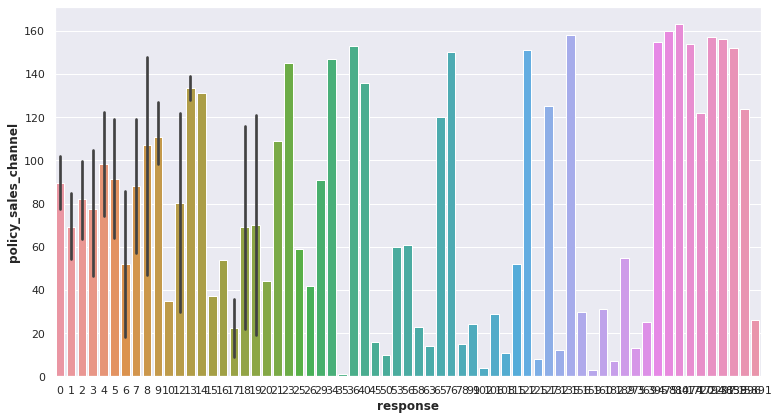

In [41]:
aux70 = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x='response', y='policy_sales_channel', data=aux70)

### Vintage

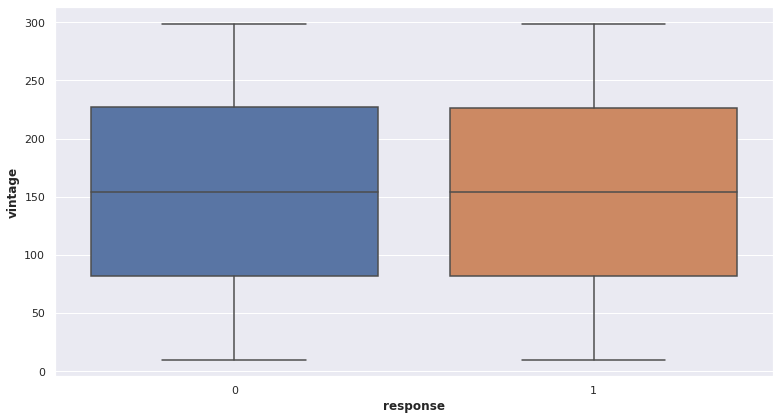

In [42]:
sns.boxplot(x='response', y='vintage', data=df4);

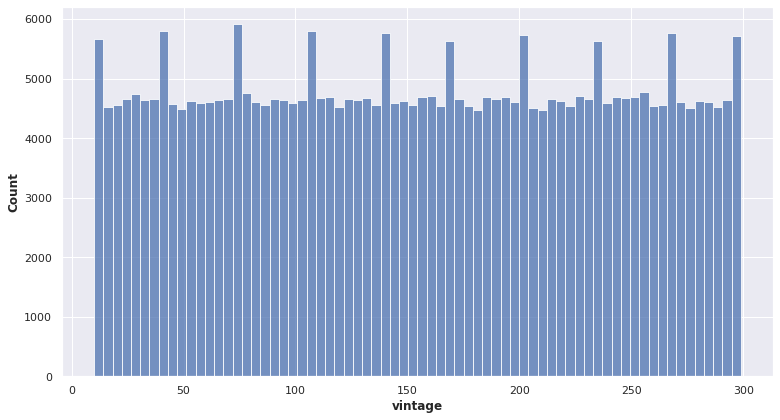

In [43]:
aux80 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux80);

## 4.2. Bivariate Analysis

In [44]:
# Create function to calculate percentage of values and plot the results
def plot_features(column):
    table_perc = df4.groupby('response')[column].value_counts(normalize = True, sort = False) * 100
    table_perc = table_perc.reset_index(name="percentage")
    
    sns.barplot(x = column, y = 'percentage', hue = 'response', data = table_perc, palette = 'hls')
    labels = [i for i in range(0,105,5)]
    plt.yticks(labels)
    plt.ylabel('Porcentagem de Interessados')
    return plt.show()


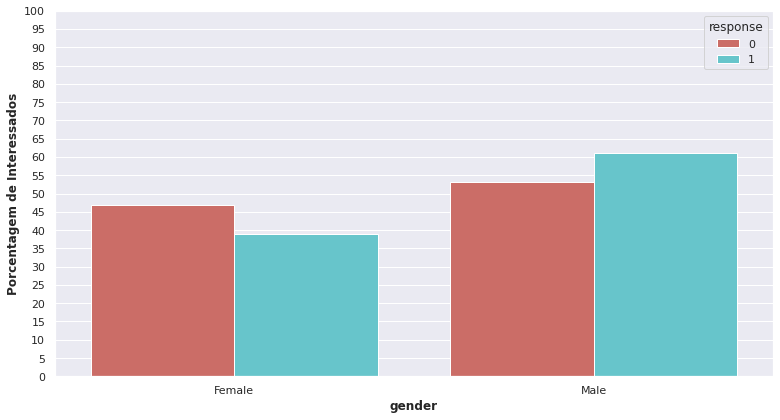

In [45]:
plot_features('gender')

In [46]:
df4.age.min()

20

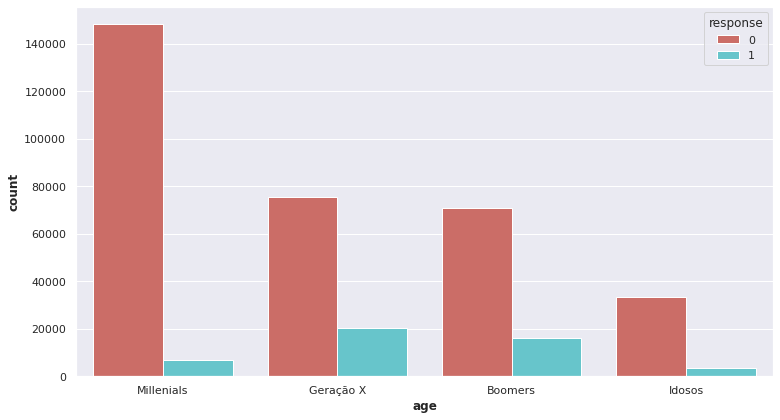

In [47]:
bins=[20, 30, 45, 62, 85]
labels=['Millenials', 'Geração X', 'Boomers', 'Idosos']
biva1 = pd.cut(df4.age, bins=bins, labels=labels)
biva1
# plot_features(biva1)
sns.countplot(x=biva1, data=df4, hue='response', palette='hls');

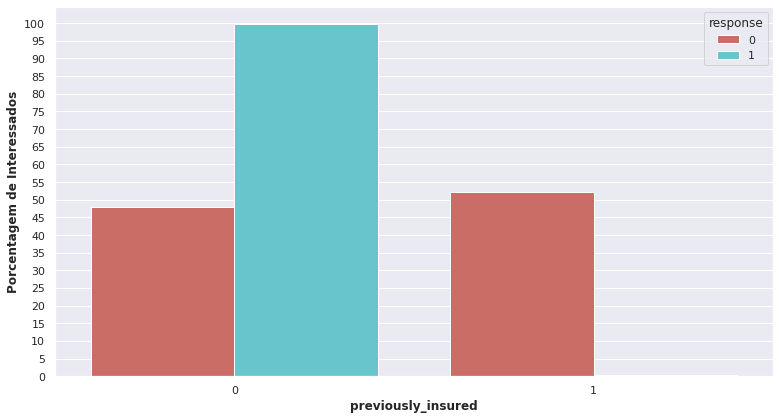

In [48]:
plot_features('previously_insured')

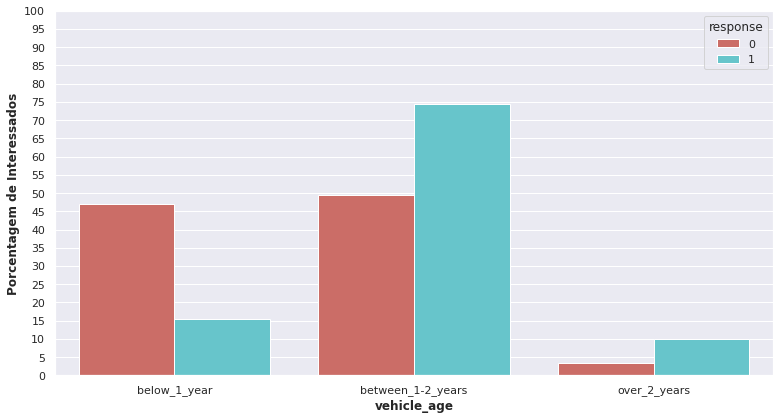

In [49]:
plot_features('vehicle_age')

## 4.3. Multivariate Analysis

# 5.0 DATA PREPARATION

In [50]:
df5 = df4.copy()

In [51]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2)

df5 = pd.concat([X_train, y_train], axis=1)

## Standardization

In [52]:
ss = StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

## Rescaling

In [53]:
mms = MinMaxScaler()

# age
df5['age'] = mms.fit_transform(df5[['age']].values)

# vintage
df5['vintage'] = mms.fit_transform(df5[['vintage']].values)

## Encoding

In [54]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)

# region_code - Frequency Encoding / Target Encoding / Weighted Target Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)

# vehicle_age - One Hot Encoding / Frequency Encoding / Order Encoding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)

## 5.4 Validation Process

In [55]:
# gender
X_validation.loc[:, 'gender'] = X_validation.loc[:, 'gender'].map(target_encode_gender)

# age
X_validation.loc[:, 'age'] = mms.transform(X_validation[['age']].values)

# region_code
X_validation.loc[:, 'region_code'] = X_validation.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle_age
X_validation = pd.get_dummies(X_validation, prefix='vehicle_age', columns=['vehicle_age'])

# annual_premium
X_validation.loc[:, 'annual_premium'] = ss.transform(X_validation[['annual_premium']].values)

# policy_sales_channel
X_validation.loc[:, 'policy_sales_channel'] = X_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
X_validation.loc[:, 'vintage'] = mms.transform(X_validation[['vintage']].values)

# fillna
X_validation = X_validation.fillna(0)

# 6.0 FEATURE SELECTION

In [56]:
df6 = df5.copy()

## 6.2 Features Importance

In [57]:
# model definition
et = ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
X_train_n = df5.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
et.fit(X_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking:

                         feature  importance
0                        vintage    0.272198
0                 annual_premium    0.244370
0                            age    0.166820
0                    region_code    0.104968
0                 vehicle_damage    0.069611
0           policy_sales_channel    0.060486
0             previously_insured    0.054134
0       vehicle_age_below_1_year    0.013704
0  vehicle_age_between_1-2_years    0.005995
0                         gender    0.004934
0       vehicle_age_over_2_years    0.002279
0                driving_license    0.000501


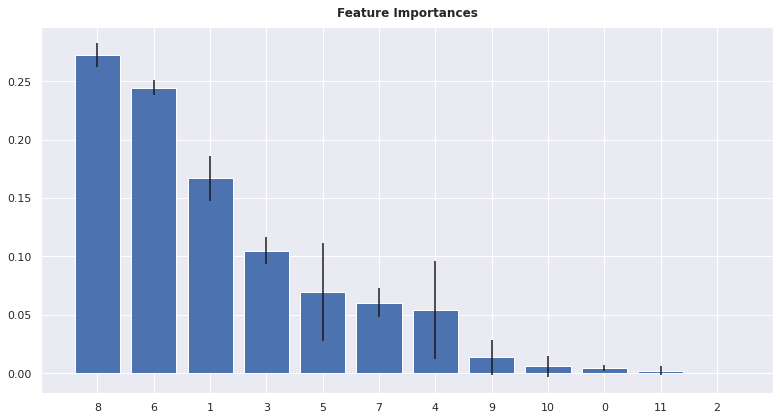

In [58]:
importances = et.feature_importances_
std = np.std([tree.feature_importances_ for tree in et.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature Ranking:\n")
df = pd.DataFrame()
for i, j in zip(X_train_n, et.feature_importances_):
    aux = pd.DataFrame({'feature': i , 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train_n.shape[1]), importances[indices], color="b", yerr=std[indices], align="center")
plt.xticks(range(X_train_n.shape[1]), indices)
plt.xlim([-1, X_train_n.shape[1]])
plt.show()



# 7.0 MODEL EVALUATION

In [59]:
df7 = df6.copy()

In [60]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 
                'previously_insured', 'policy_sales_channel']

X_train = df5[cols_selected]
X_val = X_validation[cols_selected]

## 7.1 KNN

In [61]:
# model definition
knn_model = KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(X_train, y_train)

# model prediction - Generalization Power
yhat_knn = knn_model.predict_proba(X_val)

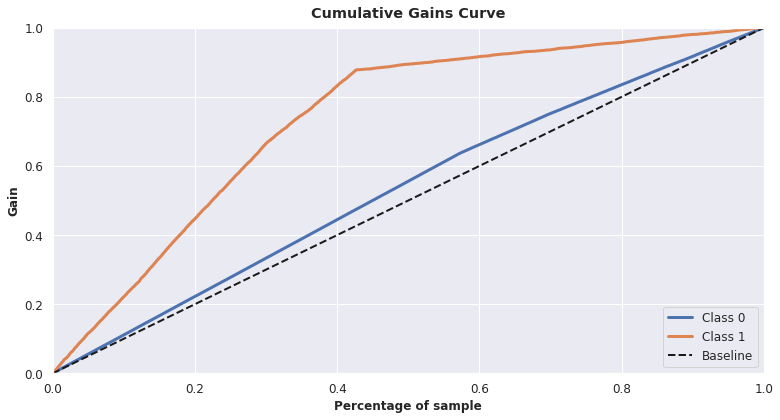

In [62]:
# Accumulative Gain
plot_cumulative_gain(y_validation, yhat_knn)
plt.show()

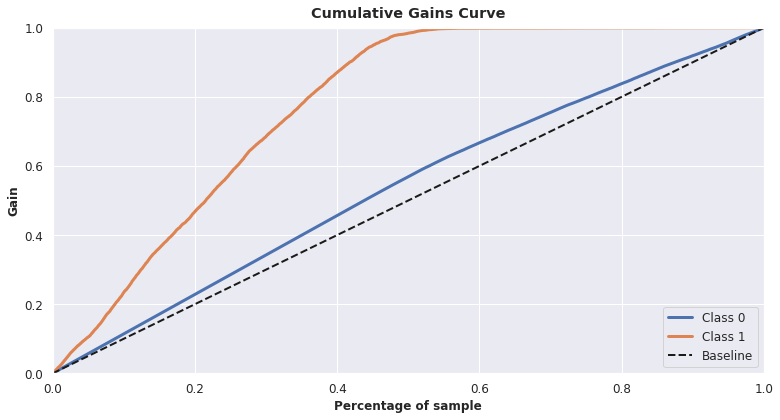

In [64]:
# model definition
logreg_model = LogisticRegression(random_state=42)

# model fit
logreg_model.fit(X_train, y_train)

# model prediction
yhat_logreg = logreg_model.predict_proba(X_val)

# Acumulative gain
plot_cumulative_gain(y_validation, yhat_logreg)
plt.show()

## 7.2 Extra Trees

In [65]:
# # model definition
# et_model = ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=42)

# # model fit
# et_model.fit(X_train, y_train)

# # model prediction
# yhat_et = et_model.predict_proba(X_val)

## 7.3 Random Forest

## 7.4 XGB

# 8.0 HYPERPARAMETER FINE-TUNING

In [70]:
def precision_at_k(data, k=2000):
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']

In [71]:
def recall_at_k(data, k=2000):
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_at_k']

In [74]:
# copy data
df8 = X_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_knn[:, 1].tolist()

# sort clients by propensity score
df8 = df8.sort_values('score', ascending=False)

# compute Precision at K
precision_at_50 = precision_at_k(df8, 50)
recall_at_50 = recall_at_k(df8, 50)
print(f"Precision at K: {precision_at_50:.5f}\nRecall at K:{recall_at_50:.5f}")

Precision at K: 0.31373
Recall at K:0.00169


In [75]:
df8.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_below_1_year,vehicle_age_between_1-2_years,vehicle_age_over_2_years,response,score
375159,375160,0.103593,0.166090,1,0.187171,0,1,0.308787,0.209258,0.138408,0,1,0,1,1.0
149520,149521,0.137789,0.159170,1,0.130583,0,1,-1.620161,0.194223,0.685121,0,1,0,1,1.0
247590,247591,0.103593,0.217993,1,0.121528,0,1,0.194115,0.194223,0.806228,0,0,1,0,1.0
370208,370209,0.137789,0.131488,1,0.187171,0,1,0.705934,0.209258,0.083045,0,1,0,1,1.0
7927,7928,0.103593,0.138408,1,0.099548,0,1,-1.620161,0.209258,0.269896,0,1,0,0,1.0


# 9.0 MODEL SELECTION

In [ ]:
df9 = df8.copy()

# 10.0 PRODUCTION DEPLOYMENT 

In [ ]:
df10 = df9.copy()